### Task Description 

The objective is to predict whether the customer is multisim (uses more than one SIM Card).

Given data is represented by the following features: 
* **id**                           : unique customer id 
* **mg_traffic_in**                : longdistance traffic 
* **tp_code**                      : tariff plan code 
* **num_voice_out**                : outgoing calls
* **tp_change_date**               : tariff plan change date
* **uniq_calls_cnt**               : number of unique phone numbers called
* **age_cat**                      : age category 
* **tech_sms_cnt_3m**              : number of technical SMS for 3 months
* **tech_sms_cnt_6m**              : number of technical SMS for 6 months
* **called_ctn_all_group**         : incoming calls group 
* **device_cost**                  : device cost
* **traf_kb**                      :  internet traffic (kb) 
* **sim_type**                     : device sim type
* **gender_male_prob**             : gender probability
* **complex_value_sum**            : complex customer value 	
* **complex_value_size**           : complex customer size 
* **imei_cnt**                     : IMEI count  
* **main_balance_adjust_minus_cnt**: number of balance adjustments  
* **state_code**                   : region code
* **macro_state**                  : macro region 
* **time_onnet**                   : time on net  
* **sum_recharges_3m**             : recharges sum for 3 months
* **year**                    : year
* **month**                        : month 
* **target**                       : is multisim flag	




In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [2]:
matplotlib.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 25)

In [3]:
df = pd.read_excel(r'C:\Users\artyo\OneDrive\Рабочий стол\task\multisim_dataset.xlsx')

# Some rows have missing target value. Drop them
df = df[df['target'].isna() == False]

print('Data dimension:', df.shape)

Data dimension: (73249, 25)


In [4]:
# Rows example 
df.head(7)

,id,mg_traffic_in,tp_code,num_voice_out,tp_change_date,uniq_calls_cnt,age_cat,tech_sms_cnt_3m,tech_sms_cnt_6m,called_ctn_all_group,device_cost,traf_kb,sim_type,gender_male_prob,complex_value_sum,complex_value_size,imei_cnt,main_balance_adjust_minus_cnt,state_code,macro_state,time_onnet,sum_recharges_3m,year,month,target
2,103,0.00,3.0,22.0,NaT,58,3,162.0,246.0,0.0,13689.0,0,DualSim,0.928517,20658.000000,1.000000,1.0,NaN,VIP,1,2703,366.04,2019,1,1.0
3,104,0.00,4.0,30.0,NaT,61,10,NaN,NaN,0.0,490.0,0,DualSim,0.644491,18045.000000,2.666667,1.0,NaN,KCH,1,1153,1122.58,2019,1,1.0
4,105,0.80,5.0,29.0,NaT,49,0,66.0,130.0,1.0,16051.0,0,DualSim,0.949505,9032.000000,1.000000,1.0,1.333333,STV,1,2174,633.20,2019,1,0.0
6,107,1.10,7.0,230.0,NaT,166,7,0.0,14.0,4.0,7490.0,65383424,DualSim,0.888604,41027.000000,3.000000,1.0,1.000000,IRK,1,515,1200.00,2019,1,1.0
7,108,90.06,8.0,152.0,NaT,37,8,NaN,NaN,4.0,-1.0,0,DualSim,0.204310,14158.000000,1.333333,1.0,NaN,RND,1,2102,850.00,2019,1,0.0
8,109,3.70,9.0,9.0,NaT,56,2,394.0,720.0,1.0,9563.0,0,DualSim,0.921841,23772.000000,1.000000,1.0,NaN,KRD,1,2033,0.00,2019,1,0.0
11,112,0.00,12.0,0.0,NaT,30,2,NaN,NaN,0.0,8194.0,3823588352,DualSim,0.816061,13343.333333,5.000000,2.0,1.000000,VLD,1,787,240.06,2019,1,0.0


In [5]:
# Constructing date using year and month

df['dt'] = pd.to_datetime(df['month'].apply(lambda x: str(x) if x >= 10 else '0' + str(x)) + '-' + df['year'].astype(str))
df.drop(columns = ['month', 'year'],
        inplace = True)

In [6]:
# Number of unique customers

print('Number of unique customers:', df['id'].unique().shape[0])

Number of unique customers: 24935


In [7]:
# Checking for duplicates for each pair id/dt 

df[['id', 'dt']].duplicated().sum()

0

In [8]:
# Seems to be that each id has rows with different date 
df.groupby('id').size().describe()

count    24935.000000
mean         2.937598
std          0.241890
min          2.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          3.000000
dtype: float64

In [9]:
# Data filled unevenly for different date
# Feature 'tp_change_date' can be broadcasted for all id rows if 'tp_change_date' less that date 

df[df['id'] == 112]

,id,mg_traffic_in,tp_code,num_voice_out,tp_change_date,uniq_calls_cnt,age_cat,tech_sms_cnt_3m,tech_sms_cnt_6m,called_ctn_all_group,device_cost,traf_kb,sim_type,gender_male_prob,complex_value_sum,complex_value_size,imei_cnt,main_balance_adjust_minus_cnt,state_code,macro_state,time_onnet,sum_recharges_3m,target,dt
11,112,0.00,12.0,0.0,NaT,30,2,NaN,NaN,0.0,8194.0,3823588352,DualSim,0.816061,13343.333333,5.0,2.0,1.0,VLD,1,787,240.06,0.0,2019-01-01
30011,112,1.45,12.0,NaN,2017-02-27,30,2,NaN,NaN,0.0,8194.0,3823588352,DualSim,0.816061,13343.333333,5.0,2.0,1.0,VLD,1,787,240.06,0.0,2019-02-01
60011,112,0.00,12.0,NaN,NaT,30,2,NaN,NaN,0.0,8194.0,3823588352,DualSim,0.816061,13343.333333,5.0,2.0,1.0,VLD,1,787,240.06,0.0,2018-12-01


In [10]:
# Checking if there are customers with different target on different date
# No such ids 
df[['id', 'target']].drop_duplicates().groupby(['id', 'target']).size().describe()

count    25070.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
dtype: float64

In [11]:
# Checking missing data rate for different dates 
date_list = df['dt'].unique()

for dt in date_list:
    print('DATE:',dt,
          end = '\n\n')
    
    print(df[df['dt']  == dt].isna().sum(),
          end = '\n\n')
    
    print('Total missing values:', df[df['dt']  == dt].isna().sum().sum(),
           end = '\n\n\n\n')

DATE: 2019-01-01T00:00:00.000000000

id                                   0
mg_traffic_in                        0
tp_code                              5
num_voice_out                        0
tp_change_date                   24223
uniq_calls_cnt                       0
age_cat                              0
tech_sms_cnt_3m                   7616
tech_sms_cnt_6m                   7616
called_ctn_all_group                25
device_cost                        540
traf_kb                              0
sim_type                           414
gender_male_prob                     0
complex_value_sum                   15
complex_value_size                  15
imei_cnt                           127
main_balance_adjust_minus_cnt    15746
state_code                           0
macro_state                          0
time_onnet                           0
sum_recharges_3m                     0
target                               0
dt                                   0
dtype: int64

Total missing

#### Data preprocessing strategy
1. Considering the fact that customer's target is constant for each customer id, data should include **only one row per each id** to represent each customer as unique (deduplication).
2. Some features (such as tp_change_date) could be broadcasted for each customer id from one date to others.
3. The date representing each id should be choosen by the least missing data rate.

<br>
In view of the above, choosen date is '2019-01-01' as the moment of least missing data (considering broadcasting from '2019-02-01')

In [12]:
# broadcasting 'tp_change_date' and constructing flag of tariff plan changing 

df['tp_change_date'] = df.groupby('id')['tp_change_date'].apply(lambda x: x.bfill().ffill())
df['tp_change_flg'] = (df['dt'] > df['tp_change_date']).apply(lambda x: 1 if x else 0)
                                              
df.drop(columns = ['tp_change_date'],
        inplace = True)

In [13]:
# moment of the least missing data 

df = df[df['dt'] == '2019-01-01']

Iterating through different features shown that most valuable combination includes the following:

In [14]:
# Flag of dualsim customer device 

df['is_dual'] = df['sim_type'].apply(lambda x: 1 if x == 'DualSim' else 0)
df.drop(columns = ['sim_type'], inplace = True)


# Missing values mean absence of balance adjustings/ technical sms 
df['tech_sms_cnt_3m'].fillna(0, inplace = True)
df['tech_sms_cnt_6m'].fillna(0, inplace = True)


# Missing rates of 'imei_cnt' and 'complex_value_sum' are close to zero 
df['imei_cnt'].fillna(df['imei_cnt'].mode().values[0], inplace = True)
df['complex_value_sum'].fillna(df['complex_value_sum'].mode().values[0], inplace = True )

In [15]:
features = ['macro_state', 'mg_traffic_in', 'num_voice_out', 'tech_sms_cnt_3m', 'tech_sms_cnt_6m',
            'complex_value_sum', 'imei_cnt', 'gender_male_prob', 'time_onnet', 'is_dual', 'tp_change_flg']

#### Model building

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [17]:
train_df, test_df = train_test_split(df[features + ['target']],
                                     test_size =  0.3)

X_train, Y_train = train_df.drop(columns = 'target'), train_df['target']
X_test, Y_test = test_df.drop(columns = 'target'), test_df['target']

In [29]:
# Best rf parameters
clf = RandomForestClassifier(max_depth = 5,
                             n_estimators = 500,
                             max_features = 4,
                             class_weight = 'balanced')

clf = clf.fit(X_train, Y_train)
Y_predicted = clf.predict(X_test)

In [30]:
# Result metrics 

accuracy = accuracy_score(Y_predicted, Y_test)
recall = recall_score(Y_predicted, Y_test)
precision = precision_score(Y_predicted, Y_test)

print('Accuracy score:', accuracy,
      end = '\n\n')
print('Recall score:', recall,
      end = '\n\n')
print('Precision score:', precision)

Accuracy score: 0.9519746800605476

Recall score: 0.9925256929305513

Precision score: 0.9074601366742597


Feature ranking:
macro_state: 0.947178
num_voice_out: 0.026327
is_dual: 0.006702
imei_cnt: 0.004478
time_onnet: 0.004008
complex_value_sum: 0.002824
tech_sms_cnt_6m: 0.002708
tech_sms_cnt_3m: 0.002219
gender_male_prob: 0.001700
mg_traffic_in: 0.001045
tp_change_flg: 0.000812


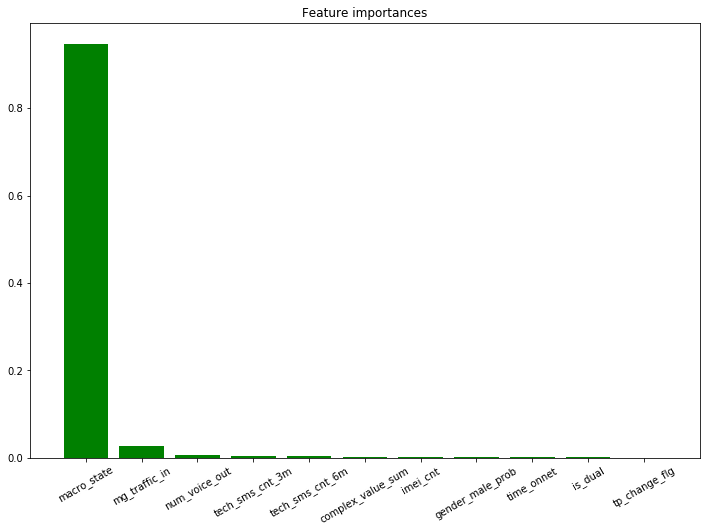

In [31]:
# feature ranking
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print('Feature ranking:')
for f in range(X_train.shape[1]):
    print('%s: %f' % (X_train.columns[indices[f]], importances[indices[f]]))
# Plot the feature importances of the forest
plt.figure()
plt.title('Feature importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color = 'green', 
        align = 'center')

plt.xticks(range(X_train.shape[1]), X_train.columns,  rotation = 30)
plt.xlim([-1, X_train.shape[1]])
plt.show()